In [82]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [83]:
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [84]:
class RKHS_classifier:
    def __init__(self,  kernel = 'rbf', degree = 3, reg_const = 1.0, sigma = None, verbose = False):


        if kernel == 'rbf':
            self.kernel_fn = self.Gaussian_kernel
        elif kernel == 'poly':
            self.kernel_fn = self.Polynomial_kernel
            self.degree = degree
        elif kernel == 'linear':
            self.kernel_fn = self.Linear_kernel
        
        self.relu = torch.nn.ReLU()
        self.C = reg_const
        self.sigma = sigma
        self.verbose = verbose
    

    def Gaussian_kernel(self, a, b):
        val = torch.exp((-1) *(torch.sum((a-b)**2))/(2*(self.sigma**2)))
        return val
    def Polynomial_kernel(self, a, b):
        val = (torch.matmul(a,b) + 1)**self.degree
        return val
    def Linear_kernel(self, a,b):
        val = torch.matmul(a,b)
        return val
    
    def fit(self, features, labels, n_iters = 500):
        self.x = features.float()
        self.y = labels.reshape(-1,1).float()

        self.rows, self.cols = features.shape
        self.sigma = 1/self.cols if self.sigma is None else 1.0

        
        # Computing kernel matrix
        if self.verbose: print("Computing kernel matrix... ", end = "")
        self.kernel = torch.zeros(size = (self.rows, self.rows), dtype = torch.float, requires_grad = False)
        for i in range(self.rows):
            for j in range(i, self.rows):
                self.kernel[i,j] = self.kernel_fn(self.x[i], self.x[j])
                self.kernel[j,i] = self.kernel[i,j]
        if self.verbose:print("Done")
        

        # Optimizing over values of alpha
        if self.verbose: print("computing optimal solution... ", end = "")
        alpha = torch.zeros(size = (self.rows, 1), requires_grad = True).float()
        optimizer = torch.optim.Adam([alpha], lr = 1e-1) # Using Adam optimzier but can use SGD
        
        self.loss_rec = torch.zeros(size = (n_iters,), dtype = float)
        self.norm_rec = torch.zeros(size = (n_iters,), dtype = float)

        for i in range(n_iters):
            optimizer.zero_grad()

            # Computing Loss 
            vec1 = self.kernel @ alpha
            vec2 = self.y * vec1
            vec3 = 1 - vec2
            vec4 = self.relu(vec3)
            loss_f = torch.sum(vec4) / self.rows

            # computing Norm
            vec5 = self.kernel @ alpha
            norm_f = torch.transpose(alpha, dim0 = 0, dim1 = 1) @ vec5

            J_f = loss_f + self.C * norm_f

            J_f.backward() # Populating the graph with gradients

            optimizer.step() # Updating alpha

            self.loss_rec[i] = loss_f.item()
            self.norm_rec[i] = norm_f.item()
        
        self.alpha = alpha.detach()
        if self.verbose:print("Done")

    def predict(self, features = None): #Use 'features = None' when predictions are to be done on training data
        if features is None:
            pred = (self.kernel @ self.alpha).reshape(-1)
            return pred
        else:
            n = features.shape[0]
            pred = torch.empty(size = (n,), dtype = float)
            for i in range(n):
                s = 0
                for j in range(self.rows):
                    s += self.alpha[j] * self.kernel_fn(features[i], self.x[j])
                pred[i] = s
            return pred


We consider the problem: $$\text{min}_{f\in H}\quad C{\lVert f\rVert}_{H}^{2}+\frac{1}{n}\sum_{i=1}^{n}L(f(x_i), y_i)$$

The kernels used are: $\newline$
i. Gaussian kernel (or rbf kernel): $$K(x,x') = \exp\bigg(-\frac{{\lVert x-x^{'}\rVert}^{2}}{2\sigma^{2}}\bigg)$$

ii. Polynomial Kernel (with degree d): $$K(x,x^{'}) = (x^{T}x^{'}+1)^{d}$$

iii. Linear Kernel: $$K(x,x^{'}) = x^{T}x^{'}$$

For our case we have used the Loss function: $$L(x,y) = \text{max}(0, 1-yf(x))$$

# Example Data

In [170]:
n = 300
x = torch.rand(size = (n, 2))
y = torch.zeros(size = (n,))
for i in range(n):
    # r = np.sqrt((x[i,0]-0.5)**2 + (x[i,1]-0.5)**2)
    r = torch.sqrt(torch.sum((x[i]-0.5)**2))

    y[i] = 1.0 if r<0.4 and r>0.2 else -1.0

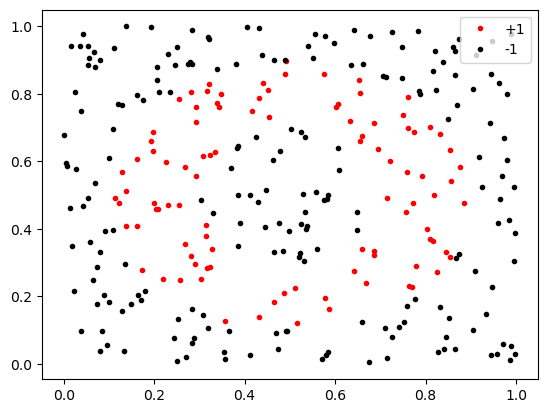

In [171]:
class1 = x[y>0]
class2 = x[y<0]
plt.plot(class1[:,0], class1[:,1], '.', color = 'red', label = '+1')
plt.plot(class2[:,0], class2[:,1], '.', color = 'black', label = '-1')
plt.legend()
plt.show()

In [176]:
clf = RKHS_classifier('rbf', degree = 10, reg_const = 1e-4, verbose = True)

Computing kernel matrix... Done
computing optimal solution... Done


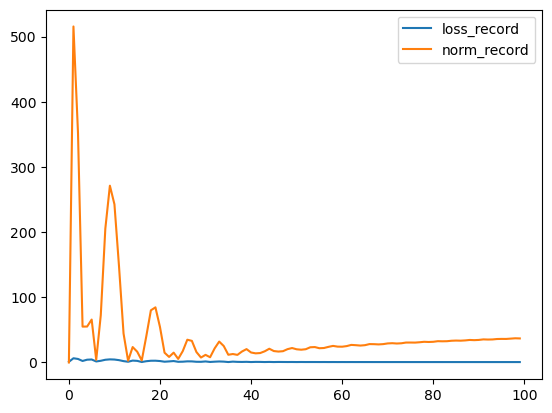

In [177]:
clf.fit(x, y, n_iters = 100)
plt.plot(clf.loss_rec, label = 'loss_record')
plt.plot(clf.norm_rec, label = 'norm_record')
plt.legend()
plt.show()

Accuracy = 68.67%


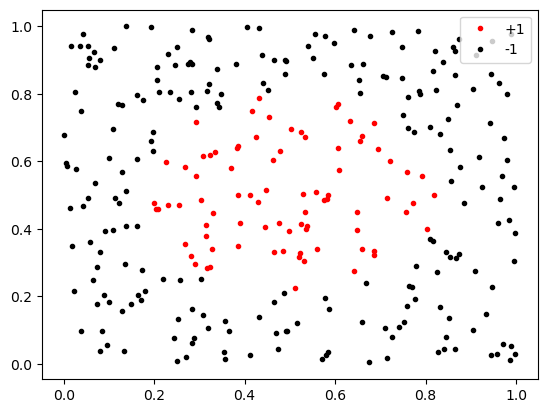

In [178]:
# Predicting on training data
pred =clf.predict()

# computing accuracy
pred_label = torch.sign(pred)
num_correct = torch.sum(torch.nn.functional.relu(pred_label * y))
num_samples = x.shape[0]
accuracy = (num_correct/num_samples)*100
print(f"Accuracy = {accuracy.item():.2f}%",)

class1 = x[pred>0]
class2 = x[pred<0]
plt.plot(class1[:,0], class1[:,1], '.', color = 'red', label = '+1')
plt.plot(class2[:,0], class2[:,1], '.', color = 'black', label = '-1')
plt.legend()
plt.show()



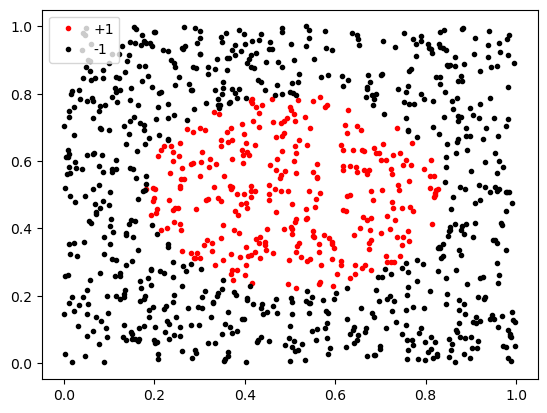

In [179]:
x_ = torch.rand(size = (1000, 2)).float()
pred = clf.predict(x_)

class1 = x_[pred>0]
class2 = x_[pred<0]
plt.plot(class1[:,0], class1[:,1], '.', color = 'red', label = '+1')
plt.plot(class2[:,0], class2[:,1], '.', color = 'black', label = '-1')
plt.legend()
plt.show()

# IRIS Data

In [91]:
from sklearn import datasets
iris = datasets.load_iris()

In [92]:
iris['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [93]:
features = iris['data']
labels = iris['target']

# We will keep only setosa and versicolor
features = features[labels != 2]
labels = labels[labels != 2]
labels = 2*(labels - 0.5) #  Making the labels 1 for versicolor and -1 for setosa

# Converting them to tensor
features = torch.tensor(features)
labels = torch.tensor(labels)

In [139]:
clf_iris = RKHS_classifier('rbf', degree = 4, reg_const = 0.1, verbose = True)

Computing kernel matrix... Done
computing optimal solution... Done


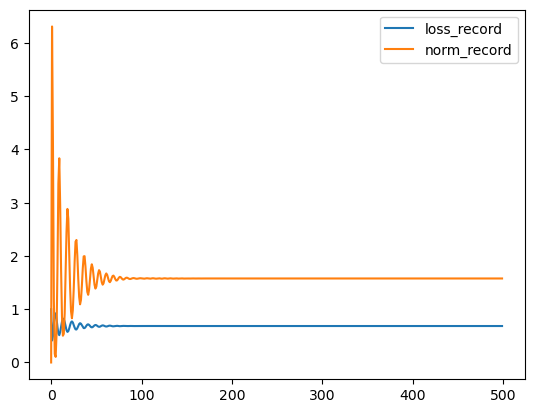

In [140]:
clf_iris.fit(features, labels, n_iters = 500)

#Plotting the loss and norm records
plt.plot(clf_iris.loss_rec, label = 'loss_record')
plt.plot(clf_iris.norm_rec, label = 'norm_record')
plt.legend()
plt.show()

In [141]:
# Predicting on training data
pred = clf_iris.predict()

# computing accuracy
pred_label = torch.sign(pred)
num_correct = torch.sum(torch.nn.functional.relu(pred_label * labels))
num_samples = features.shape[0]
accuracy = (num_correct/num_samples)*100
print(f"Accuracy = {accuracy.item():.2f}%",)


Accuracy = 100.00%


In [142]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, train_size = 0.9, random_state = 0)

### Training on partial data

Computing kernel matrix... Done
computing optimal solution... Done


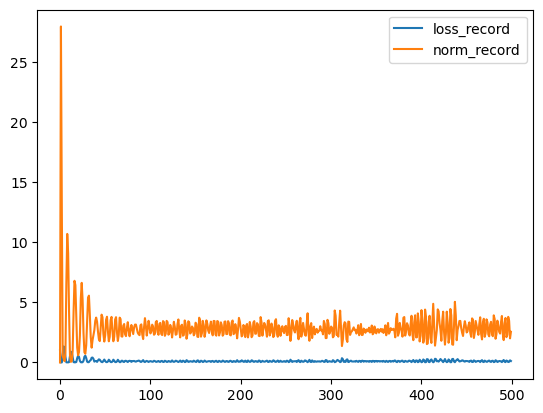

In [143]:
clf_iris.fit(features_train, labels_train, n_iters = 500)

# Plotting the norm and loss records
plt.plot(clf_iris.loss_rec, label = 'loss_record')
plt.plot(clf_iris.norm_rec, label = 'norm_record')
plt.legend()
plt.show()

In [99]:
# Predicting on training data
pred_train = clf_iris.predict()

# computing accuracy
pred_label_train = torch.sign(pred_train)
num_correct = torch.sum(torch.nn.functional.relu(pred_label_train * labels_train))
num_samples = features_train.shape[0]
accuracy = (num_correct/num_samples)*100
print(f"Training Accuracy = {accuracy.item():.2f}%",)


Training Accuracy = 100.00%


In [100]:
# Predicting on training data
pred_test = clf_iris.predict(features_test)

# computing accuracy
pred_label_test = torch.sign(pred_test)
num_correct = torch.sum(torch.nn.functional.relu(pred_label_test * labels_test))
num_samples = features_test.shape[0]
accuracy = (num_correct/num_samples)*100
print(f"Testing Accuracy = {accuracy.item():.2f}%",)


Testing Accuracy = 100.00%


# Titanic Data

In [101]:
import pandas as pd

titanic_data = pd.read_csv("titanic.csv")
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [102]:
tdata = titanic_data.drop(columns = ['Ticket', 'Cabin', 'Name', 'PassengerId', ], inplace = False)
tdata['Pclass'] = tdata['Pclass'].astype('category')
tdata['Sex'] = tdata['Sex'].astype('category')
tdata['Embarked'] = tdata['Embarked'].astype('category')

tdata

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [130]:
vec =tdata['Pclass']
vec1 = vec[vec == 1]
n1 = vec1.shape[0]
vec2 = vec[vec == 2]
n2 = vec2.shape[0]
vec3 = vec[vec == 3]
n3 = vec3.shape[0]
print(vec1.shape[0]/891)
print(vec2.shape[0]/891)
print(vec3.shape[0]/891)
# plt.hist(vec, )

0.24242424242424243
0.20650953984287318
0.5510662177328844


In [131]:
t_ = tdata[tdata['Survived'] == 1]
vec = t_['Pclass']
vec1 = vec[vec == 1]
vec2 = vec[vec == 2]
vec3 = vec[vec == 3]
m = t_.shape[0]
print(vec1.shape[0]/n1)
print(vec2.shape[0]/n2)
print(vec3.shape[0]/n3)

0.6296296296296297
0.47282608695652173
0.24236252545824846


In [103]:
tdata.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [104]:
data = tdata.copy()
mean_age = np.mean(tdata['Age'])
data['Age'] = tdata['Age'].fillna(mean_age)
data = data.dropna(axis = 0)

In [105]:
data.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [106]:
data = pd.get_dummies(data, dtype=int)
data

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.000000,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.000000,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.000000,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.000000,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,35.000000,0,0,8.0500,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.000000,0,0,13.0000,0,1,0,0,1,0,0,1
887,1,19.000000,0,0,30.0000,1,0,0,1,0,0,0,1
888,0,29.699118,1,2,23.4500,0,0,1,1,0,0,0,1
889,1,26.000000,0,0,30.0000,1,0,0,0,1,1,0,0


In [120]:
X = data.iloc[:,1:].to_numpy()
Y = data.iloc[:,0].to_numpy()
Y = 2*(Y - 0.5)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, random_state = 100)

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
Y_train = torch.tensor(Y_train).float()
Y_test = torch.tensor(Y_test).float()


### We do a grid search using each of the kernels on the regularisation constant and the degree (when polynomial kernel is used)

##### Polynomial Kernel

In [121]:
import itertools

reg_const_range = [1e-3, 1e-4]
degree_range = [3,4,5,6]
comb = list(itertools.product(reg_const_range, degree_range))
poly_train_acc = []
poly_test_acc = []
poly_best = {'train':0, 'test':0, 'reg_const':0, 'degree': 0}
for reg_const, degree in tqdm(comb):
    torch.manual_seed(0)
    clf1 = RKHS_classifier(kernel = 'poly', reg_const = reg_const, degree = degree)
    clf1.fit(X_train, Y_train, n_iters = 500)
    
    pred = clf1.predict() 
    pred_label = torch.sign(pred)
    num_correct = torch.sum(torch.nn.functional.relu(pred_label * Y_train))
    num_samples = X_train.shape[0]
    accuracy = (num_correct/num_samples)*100
    poly_train_acc.append(accuracy)


    pred = clf1.predict(X_test)
    pred_label = torch.sign(pred)
    num_correct = torch.sum(torch.nn.functional.relu(pred_label * Y_test))
    num_samples = X_test.shape[0]
    accuracy = (num_correct/num_samples)*100
    poly_test_acc.append(accuracy)

    if poly_test_acc[-1] > poly_best['test']:
        poly_best['test'] = poly_test_acc[-1]
        poly_best['train'] = poly_train_acc[-1]
        poly_best['reg_const'] = reg_const
        poly_best['degree'] = degree


print("Best test accuracy ", poly_best['test'].item())
print("Best train accuracy ", poly_best['train'].item())
print("polynomial degree = ", poly_best['degree'])
print("reg_const", poly_best['reg_const'])

100%|██████████| 8/8 [00:56<00:00,  7.09s/it]

Best test accuracy  68.53932584269663
Best train accuracy  68.0
polynomial degree =  6
reg_const 0.001


In [122]:
print(comb)

[(0.001, 3), (0.001, 4), (0.001, 5), (0.001, 6), (0.0001, 3), (0.0001, 4), (0.0001, 5), (0.0001, 6)]


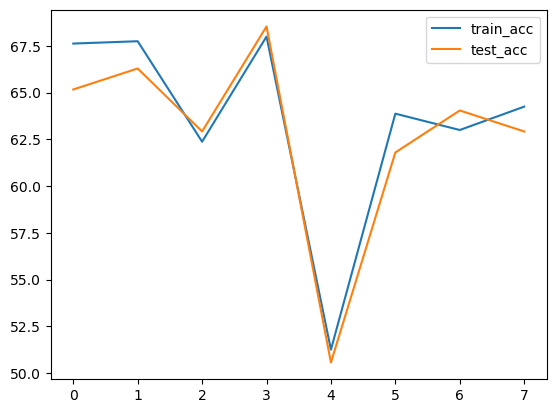

In [123]:
plt.plot(poly_train_acc, label = 'train_acc')
plt.plot(poly_test_acc, label = 'test_acc')
plt.legend()
plt.show()

##### Gaussial Kernel

In [124]:

reg_const_range = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 0]

rbf_train_acc = []
rbf_test_acc = []
rbf_best = {'train':0, 'test':0, 'reg_const':0}
for reg_const in tqdm(reg_const_range):
    torch.manual_seed(0)
    clf1 = RKHS_classifier(kernel = 'rbf', reg_const = reg_const)
    clf1.fit(X_train, Y_train, n_iters = 500)
    
    pred = clf1.predict() 
    pred_label = torch.sign(pred)
    num_correct = torch.sum(torch.nn.functional.relu(pred_label * Y_train))
    num_samples = X_train.shape[0]
    accuracy = (num_correct/num_samples)*100
    rbf_train_acc.append(accuracy)


    pred = clf1.predict(X_test)
    pred_label = torch.sign(pred)
    num_correct = torch.sum(torch.nn.functional.relu(pred_label * Y_test))
    num_samples = X_test.shape[0]
    accuracy = (num_correct/num_samples)*100
    rbf_test_acc.append(accuracy)


    if rbf_test_acc[-1] > rbf_best['test']:
        rbf_best['test'] = rbf_test_acc[-1]
        rbf_best['train'] = rbf_train_acc[-1]
        rbf_best['reg_const'] = reg_const


print("Best test accuracy ", rbf_best['test'].item())
print("Best train accuracy ", rbf_best['train'].item())
print("reg_const", rbf_best['reg_const'])

100%|██████████| 8/8 [01:21<00:00, 10.19s/it]

Best test accuracy  42.69662921348314
Best train accuracy  97.5
reg_const 0.1


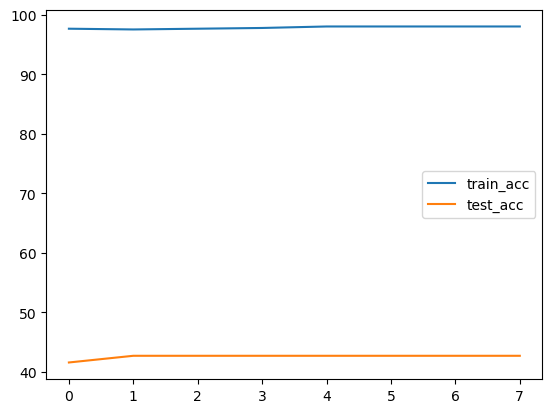

In [125]:
plt.plot(rbf_train_acc, label = 'train_acc')
plt.plot(rbf_test_acc, label = 'test_acc')
plt.legend()
plt.show()

In [126]:
reg_const_range = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 0]

linear_train_acc = []
linear_test_acc = []
linear_best = {'train':0, 'test':0, 'reg_const':0}
for reg_const in tqdm(reg_const_range):
    torch.manual_seed(0)
    clf1 = RKHS_classifier(kernel = 'linear', reg_const = reg_const)
    clf1.fit(X_train, Y_train, n_iters = 500)
    
    pred = clf1.predict() 
    pred_label = torch.sign(pred)
    num_correct = torch.sum(torch.nn.functional.relu(pred_label * Y_train))
    num_samples = X_train.shape[0]
    accuracy = (num_correct/num_samples)*100
    linear_train_acc.append(accuracy)


    pred = clf1.predict(X_test)
    pred_label = torch.sign(pred)
    num_correct = torch.sum(torch.nn.functional.relu(pred_label * Y_test))
    num_samples = X_test.shape[0]
    accuracy = (num_correct/num_samples)*100
    linear_test_acc.append(accuracy)

    if rbf_test_acc[-1] > linear_best['test']:
        linear_best['test'] = linear_test_acc[-1]
        linear_best['train'] = linear_train_acc[-1]
        linear_best['reg_const'] = reg_const

print("Best test accuracy ", linear_best['test'].item())
print("Best train accuracy ", linear_best['train'].item())
print("reg_const", linear_best['reg_const'])

100%|██████████| 7/7 [00:33<00:00,  4.85s/it]

Best test accuracy  61.79775280898876
Best train accuracy  61.75
reg_const 0.1


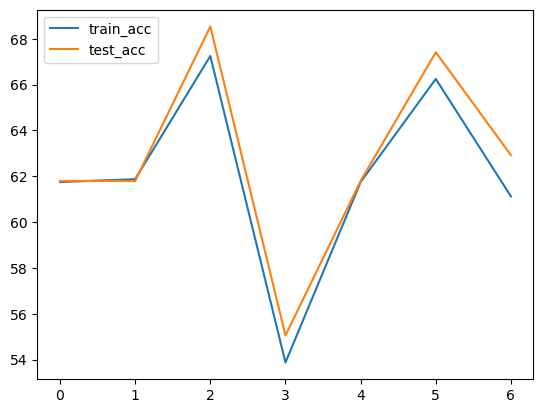

In [127]:
plt.plot(linear_train_acc, label = 'train_acc')
plt.plot(linear_test_acc, label = 'test_acc')
plt.legend()
plt.show()